# Hierarchical Neural Posterior Estimator


Consider a ill posed problem $x = \alpha \dot \beta$.
When using SBI on such problem, we obtain a posterior with infinitely many equivalent solutions: 

2024-03-22 02:21:39.984406: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 02:21:39.986655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 02:21:40.034183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 02:21:40.035206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 02:21:40.928558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 192 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/tom/.local/miniconda/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1690826107099/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  outputs, _ = torch.triangular_solve(


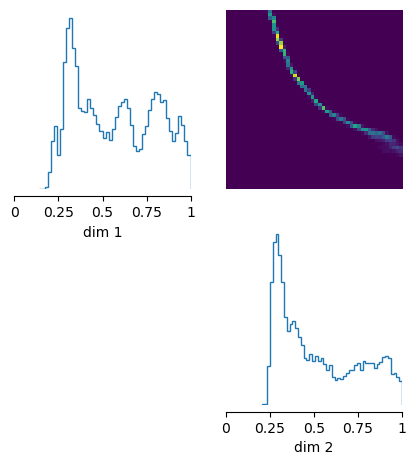

In [1]:
import torch

from sbi import analysis

from sbi.inference import SNPE
from sbi.inference import prepare_for_sbi
from sbi.inference import simulate_for_sbi
from sbi.neural_nets.factory import build_maf
from sbi.utils import BoxUniform


prior = BoxUniform(
    low=torch.tensor([0.0, 0.0]),
    high=torch.tensor([1.0, 1.0])
)


def simulator(theta):
    alpha, beta = theta[..., :1], theta[..., 1:]
    return (alpha * beta).reshape(-1, 1)


simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=100)

# setup the inference procedure
inference = SNPE(
    prior=prior,
    density_estimator=build_maf,
    show_progress_bars=True,
    device='cpu',
)
density_estimator = inference.append_simulations(theta, x).train(
    num_atoms=10,
    training_batch_size=10,
)
posterior = inference.build_posterior(density_estimator)

# plot posterior samples
x0 = torch.tensor([0.25])
posterior_samples = posterior.sample((10000,), x=x0)
_ = analysis.pairplot(
    posterior_samples, limits=[[0, 1], [0, 1], [0, 1]], figsize=(5, 5)
)

This ambiguity can some time be overcome with extra observation which share a common parameter. This is the purpose of hNPE.
To do this, let's first build a simulator with extra observation.
For this, we can use the `hierachical_simulator` helper, which can decorate a classical simulator, with parameter `n_extra` for the number of extra observation and the parameter `p_local` for drawing extra value for the non-common parameters, call here `local` parameters.
We also need to specify how many parameters are local.

In [2]:
from sbi.neural_nets.density_estimators.hierarchical_estimator import hierachical_simulator


prior = BoxUniform(
    low=torch.tensor([0.0, 0.0]),
    high=torch.tensor([1.0, 1.0])
)

p_local = BoxUniform(low=torch.tensor([0.0]), high=torch.tensor([1.0]))


@hierachical_simulator(n_extra=10, dim_local=1, p_local=p_local)
def simulator(theta):
    alpha, beta = theta[..., :1], theta[..., 1:]
    return (alpha * beta).reshape(-1, 1)


simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=100)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

Then, we can build a hierachical flow, which takes to flow building functions to construct the global and local density estimators, and perform the inference with SNPE.

In [3]:
from sbi.inference import SNPE
from sbi.neural_nets.factory import hierarchical_nn
from sbi.neural_nets.factory import build_maf

build_hierarchical = hierarchical_nn(build_maf, build_maf, 1)

# setup the inference procedure
inference = SNPE(
    prior=prior,
    density_estimator=build_hierarchical,
    show_progress_bars=True,
    device='cpu',
)
density_estimator = inference.append_simulations(theta, x).train(
    num_atoms=10,
    training_batch_size=10,
)
posterior = inference.build_posterior(density_estimator)

/home/tom/Work/prog/sbi/sbi/neural_nets/factory.py:327: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  global_flow = build_global_flow(
/home/tom/Work/prog/sbi/sbi/neural_nets/factory.py:333: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  local_flow = build_local_flow(


 Neural network successfully converged after 78 epochs.

You can now see that the posterior is better concentrated.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

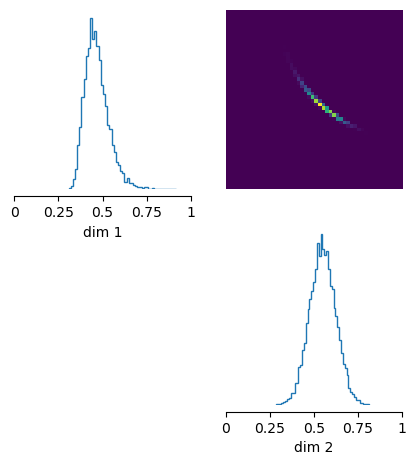

In [4]:

# plot posterior samples
x0 = simulator(torch.tensor([[0.5, 0.5]]))[0]
posterior_samples = posterior.sample((10000,), x=x0)
_ = analysis.pairplot(
    posterior_samples, limits=[[0, 1], [0, 1], [0, 1]], figsize=(5, 5)
)